In [5]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
class Infected_Person:
    def __init__(self, env, i, length_of_stay):
        self.env = env        
        self.patient_number = i
        self.length_of_stay = length_of_stay
        
        self.infected_process = env.process(self.infected(env))
        
    def infected(self, env):
        # used to be called "patient"
        glob_variables.patient_count += 1
        print("Patient {} got infected".format(self.patient_number))
        
        # request a bed
        bed_req = beds.request()
        print("Patient {} is waiting for a bed".format(self.patient_number))
        
        # start the dying process
        time_till_death = 3
        dying_p = env.process(self.dying(env, time_till_death))
        
        # wait for a bed to show up or to die
        yield bed_req | dying_p
        
        if dying_p.triggered:
            # cancel the bed request and die
            bed_req.cancel()
            # TODO: other dying logic
            print("Patient {} died and canceled the bed request".format(self.patient_number))
        else:
            print("Patient {} got a bed".format(self.patient_number))
            dying_p.interrupt('I got a bed!')
            yield env.timeout(self.length_of_stay)
            print("Patient {} recovered".format(self.patient_number))
            beds.release(bed_req)
            
        
        glob_variables.patient_count-=1
    
    def dying(self, env, time_till_death):
        # try to die but interrupt if there's a bed
        try:
            # if I die before I get the bed
            print("Patient {} is starting to die".format(self.patient_number))
            yield env.timeout(time_till_death)
        except simpy.Interrupt as i:
            # Got the bed! no need to cancel the request
            print("Patient {} death process got interrupted".format(self.patient_number))
            

def new_patient(env,infection_rate,carrying_capacity,length_of_stay):
    i = 0
    while True:
        i+=1
        # patient length of stay is drawn from exponential distribution
        p_length_of_stay = random.expovariate(1/length_of_stay)
        # create a new patient
        p = Infected_Person(env,i,p_length_of_stay)
        # define next patient based on inter arrival time
        lambd = min(7, infection_rate*i*(1-(i/carrying_capacity)))
        next_p = random.expovariate(lambd)
        # trigger event when new patient comes
        yield env.timeout(next_p)

In [23]:
def check(env, delay):
    yield env.timeout(delay)
    while True:
        glob_variables.check_times.append(env.now)
        glob_variables.check_beds.append(beds.count)
        glob_variables.check_untreated.append(glob_variables.patient_count-beds.count)
        yield env.timeout(glob_variables.check_intervals)

In [24]:
class glob_variables:
    patient_count = 0
    infection_rate = 2
    carrying_capacity = 100000
    mean_length_of_stay = 14
    max_bed_capacity = 3
    sim_duration = 50
    check_times = []
    check_beds = []
    check_untreated = []
    check_intervals = 7
    delay = 7

In [25]:
env = simpy.Environment()
beds = simpy.Resource(env, capacity = glob_variables.max_bed_capacity)
env.process(new_patient(env,glob_variables.infection_rate,glob_variables.carrying_capacity,
                        glob_variables.mean_length_of_stay))
env.process(check(env,glob_variables.delay))
env.run(until=glob_variables.sim_duration)

Patient 1 got infected
Patient 1 is waiting for a bed
Patient 1 is starting to die
Patient 1 got a bed
Patient 1 death process got interrupted
Patient 2 got infected
Patient 2 is waiting for a bed
Patient 2 is starting to die
Patient 2 got a bed
Patient 2 death process got interrupted
Patient 3 got infected
Patient 3 is waiting for a bed
Patient 3 is starting to die
Patient 3 got a bed
Patient 3 death process got interrupted
Patient 4 got infected
Patient 4 is waiting for a bed
Patient 4 is starting to die
Patient 5 got infected
Patient 5 is waiting for a bed
Patient 5 is starting to die
Patient 6 got infected
Patient 6 is waiting for a bed
Patient 6 is starting to die
Patient 7 got infected
Patient 7 is waiting for a bed
Patient 7 is starting to die
Patient 8 got infected
Patient 8 is waiting for a bed
Patient 8 is starting to die
Patient 9 got infected
Patient 9 is waiting for a bed
Patient 9 is starting to die
Patient 10 got infected
Patient 10 is waiting for a bed
Patient 10 is sta

Patient 380 got infected
Patient 380 is waiting for a bed
Patient 380 is starting to die
Patient 381 got infected
Patient 381 is waiting for a bed
Patient 381 is starting to die
Patient 352 died and canceled the bed request
Patient 353 died and canceled the bed request
Patient 382 got infected
Patient 382 is waiting for a bed
Patient 382 is starting to die
Patient 354 died and canceled the bed request
Patient 355 died and canceled the bed request
Patient 383 got infected
Patient 383 is waiting for a bed
Patient 383 is starting to die


In [119]:
Hospital_Ut = pd.DataFrame()
Hospital_Ut["Days Since Outbreak"] = glob_variables.check_times
Hospital_Ut["Bed Count"] = glob_variables.check_beds
Hospital_Ut["Untreated Patients"] = glob_variables.check_untreated

In [123]:
pd.set_option('display.max_rows',None)
Hospital_Ut

,Days Since Outbreak,Bed Count,Untreated Patients
0,7,40,0
1,14,73,0
2,21,95,0
3,28,99,0
4,35,89,0
5,42,84,0
6,49,80,0
7,56,100,2
8,63,100,1
9,70,93,0


In [93]:
def plot_graph(x,y):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(Hospital_Ut[x],Hospital_Ut[y])
    ax.set_xlabel(str(x))
    ax.set_ylabel(str(y))
    plt.xlim(0,glob_variables.sim_duration)
    plt.title("{} vs. {}".format(y,x),fontweight = "bold")

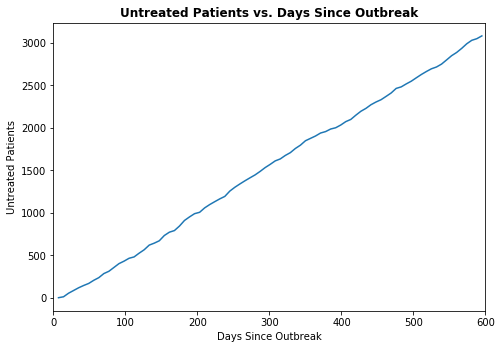

In [94]:
plot_graph("Days Since Outbreak","Untreated Patients")